In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os

In [2]:
# -------------------- edgebox RPN ----------------------------
# https://github.com/opencv/opencv_contrib/blob/master/modules/ximgproc/samples/edgeboxes_demo.py
# https://donghwa-kim.github.io/EdgeBoxes.html - 엣지박스 간단 설명

edge_model = ".\\server\\vu-visor\\model.yml.gz"
edge_detection = cv2.ximgproc.createStructuredEdgeDetection(edge_model)

def rpn(im_opencv, num_boxs, scale=1, min_score=0.01):
    """
    region proposal network
    """
    global edge_detection
    
    def makeEdgeBox(scale):
        im_opencv_scaled = cv2.resize(im_opencv, (int(im_opencv.shape[1]*scale), int(im_opencv.shape[0]*scale)), 
                                      interpolation=cv2.INTER_CUBIC).astype(np.float32)

        edges = edge_detection.detectEdges(im_opencv_scaled / 255.0)
        orimap = edge_detection.computeOrientation(edges)
        edges = edge_detection.edgesNms(edges, orimap)
        
        edge_boxes = cv2.ximgproc.createEdgeBoxes() 
        edge_boxes.setBeta(0.75) # beta=0.1, nms threshold for object proposals.
        edge_boxes.setMaxBoxes(num_boxs)
        edge_boxes.setMinScore(min_score) # box score
        boxes, scores = edge_boxes.getBoundingBoxes(edges, orimap)
        return boxes, scores, im_opencv_scaled
    
    (boxes, scores, im_opencv_scaled) = makeEdgeBox(scale)
    # bbox 하나도 없으면 전체샷이라도 저장
    if len(boxes)==0: 
        boxes=np.array([[0,0,im_opencv_scaled.shape[1],im_opencv_scaled.shape[0]]])
        scores=np.array([[min_score]])
    boxes = (boxes/scale).round().astype(np.int)
    # 박스 개수 절반보다 모자라면 스케일 키워서 한번더
    if len(boxes)<(num_boxs/2):
        scale = scale*2
        (_boxes, _scores, im_opencv_scaled) = makeEdgeBox(scale)
        if len(_boxes)>0:
            _boxes = (_boxes/scale).round().astype(np.int)
            boxes = np.concatenate([boxes,_boxes])[:num_boxs] # 이전 스케일의 박스와 concat
            scores = np.concatenate([scores,_scores])[:num_boxs]

    return torch.tensor(boxes), scores

imgPath = '.\\yolo_mark_image\\fruit\\watermelon\\w (3).jpg'
im = cv2.imread(imgPath)
%time boxes, scores = rpn(im, num_boxs=5, scale=1, min_score=0.01)
# %time boxes, scores = rpn3(im, num_boxs=5, scale=1, min_score=0.01)

for idx, (b, s) in enumerate(zip(boxes, scores)):
    x, y, w, h = b
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    cv2.putText(im, str(s[0])[:5], (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, .6, (0,0,225), 2)                             

# # cv2.imshow("edges", edges);
cv2.imshow("edgeboxes", im)
cv2.waitKey(0)
cv2.destroyAllWindows()  

Wall time: 380 ms


In [3]:
def makeAnchors(boxes):
    """
    1:1, 1:2, 2:1 *scale(1, 0.5, 0.25) 총 9가지 앵커 생성
    @params boxes - N*4 , x,y,w,h
    """
    new_boxes = []
    for box in boxes:
        x,y,w,h = box
        cx = x+w/2
        cy = y+h/2
        for s in [1, 0.5, 0.5]: # 누적곱으로 비율 게산 즉, 1, 0.5, 0.5^2
            w = w*s
            h = h*s
            x = cx-w/2
            y = cy-h/2
            # w:h = 1:2, x2,y,w2,h
            w2 = w/2
            x2 = cx-w2/2
            # w:h = 2:1, x,y2,w,h2
            h2 = h/2
            y2 = cy-h2/2
            new_box = np.array([[x,y,w,h],[x2,y,w2,h],[x,y2,w,h2]])
            new_boxes.append(new_box)
    new_boxes = np.concatenate(new_boxes).astype(np.int)
    return new_boxes

def rpn2(im, n_slice_x, n_slice_y, scale=(1,1)):
    """
    n분할 rpn
    @params im: nomalized image tensor N x C x W x H
    @return 
    """
    len_y, len_x, _ = im.shape
    w = len_x/n_slice_x
    h = len_y/n_slice_y

    cxs = [w/2+w*i for i in range(n_slice_x)]
    cys = [h/2+h*i for i in range(n_slice_y)]
    
    rois = []
    boxes = []
    for cx in cxs:
        for cy in cys:
            x=cx-w/2; y=cy-h/2
            w_diff = w*(1-scale[0])/2
            h_diff = h*(1-scale[1])/2
            w_modi = w*scale[0]
            h_modi = h*scale[1]
            x_modi = x+w_diff
            y_modi = y+h_diff

            boxes.append([max(0,x_modi),max(0,y_modi),w_modi,h_modi]) # x,y,w,h

    boxes = np.array(boxes)
    new_boxes = makeAnchors(boxes)
    return torch.tensor(new_boxes)

im = cv2.imread(".\\ttt\\2.jpg")
%time boxes = rpn2(im, n_slice_x=2, n_slice_y=1, scale=[1.5, 1])
for idx, b in enumerate(boxes):
    x, y, w, h = b
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)

cv2.imshow("edgeboxes", im)
cv2.waitKey(0)
cv2.destroyAllWindows()   

Wall time: 0 ns


In [4]:
from itertools import combinations, permutations
def rpn3(im, n_slice_x, n_slice_y):
    """
    n분할 rpn 조합
    @params box: x,y,w,h
    @return 
    """
    sx = 0
    sy = 0
    sh, sw, _ = im.shape
    w = sw/n_slice_x
    h = sh/n_slice_y
    
    rois = []
    boxes = []
    
    coords = np.array(np.meshgrid(list(range(n_slice_x+1)), list(range(n_slice_y+1)))).T.reshape(-1,2)
    
    for a,b in combinations(coords,2):
        if a[0]>=b[0] or a[1]>= b[1]: continue # 넓이 없는 사각형 제거
#         print(a,b)
        boxes.append([sx+a[0]*w, sy+a[1]*h, 
                      (b[0]-a[0])*w, (b[1]-a[1])*h]) # x,y,w,h

    boxes = torch.tensor(boxes)
    return boxes

im = cv2.imread(".\\ttt\\2.jpg")
%time boxes = rpn3(im, n_slice_x=4, n_slice_y=4)
for idx, b in enumerate(boxes):
    x, y, w, h = b
    cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA)
print(boxes.shape)
cv2.imshow("edgeboxes", im)
cv2.waitKey(0)
cv2.destroyAllWindows()   

Wall time: 1e+03 µs
torch.Size([100, 4])


In [17]:
rpn3(im, n_slice_x=1, n_slice_y=1).shape

torch.Size([1, 4])

In [6]:
class MyDataset(Dataset):
    """My dataset."""

    def __init__(self, root_dir, class_path, transform=None):
        super(MyDataset, self).__init__()
        self.root_dir = root_dir
        self.class_path = class_path
        self.transform = transform
        
        # get image list
        all_list =  [os.path.splitext(f) for f in os.listdir(self.root_dir)] # jpg + txt
        assert [f for f,e in all_list if e=='.jpg'] == [f for f,e in all_list if e=='.txt'], "num_image != num_txt"
        self.data_list = [f for f,e in all_list if e=='.jpg']
        
        # get class list
        with open(class_path, 'r', encoding='utf-8') as f:
            self.classes = [c for c in f.read().split('\n')]
        self.class_to_idx = {self.classes[i]: i for i in range(len(self.classes))}

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.data_list[idx]+'.jpg')
        ann_path = os.path.join(self.root_dir, self.data_list[idx]+'.txt')
        img = Image.open(image_path)
        with open(ann_path, 'r') as f:
            anno = [a.split(' ') for a in f.read().strip().split('\n')]
        anno = np.array(anno)
        labels = anno[:,0].astype(np.int) #- 10
        bboxes_yolo = anno[:,1:].astype(np.float) # centerX, centerY, w, h [ratio] - yolo style
        bboxes = bboxes_yolo.copy() # x,y,w,h

        if self.transform:
            img = self.transform(img).unsqueeze(0)
            
        bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*img.shape[3] # x
        bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*img.shape[2] # y
        bboxes[:,2] = bboxes_yolo[:,2]*img.shape[3]
        bboxes[:,3] = bboxes_yolo[:,3]*img.shape[2]
        bboxes = bboxes.astype(np.int)

        return img, labels, bboxes, bboxes_yolo

---
# Classification

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from torch.distributions.multivariate_normal import MultivariateNormal
from tqdm import tqdm_notebook as tqdm
# import mymodels
# from mymodels.BN_Inception import BN_Inception

def my_cos(x,y):
    _x = F.normalize(x, p=2, dim=1)
    _y = F.normalize(y, p=2, dim=1)
    return _x.matmul(_y.transpose(0,1))

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
class OracleModel(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(OracleModel, self).__init__()
#         ****torch pretrained net****
#         net = models.shufflenetv2.shufflenet_v2_x1_0(pretrained=True) # 1024
#         net = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
#         net = models.mobilenet_v2(pretrained=True)
#         net = models.densenet201(pretrained=True)
        net = models.resnet50(pretrained=True)

        modules = list(net.children())[:-2]      # resnet conv_5
        self.backbone = torch.nn.Sequential(*modules) # 2048
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten() 
        
        # fc layer
        self.fc = nn.Sequential(
            avg_pool,
            flatten
        ) # 2048
    
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.topk = 3
        self.threshold = 0.75
        self.feature_len = 2048

        self.sort_order_descending = False
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.roi_upsample = nn.UpsamplingBilinear2d([224,224])
        self.roi_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
        
    def embed(self, images):
        r = self(images)
        return self.fc(r)

    def forward(self, images):
        """Extract feature vectors from input images."""
        return self.backbone(images)
#         return self.backbone(images)[3]    
    

    def makeAllReference_online(self, referenceImgDirPath):
        """
        임베딩 디비 생성... flask 서버용 
        utils.makeAllReferenceCSV 에서 csv 저장만 안함
        """
        reference_dataset = torchvision.datasets.ImageFolder(
            root=referenceImgDirPath,
            transform=transforms.Compose([
#                 transforms.Resize([224,224]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        )
        reference_loader = torch.utils.data.DataLoader(
            reference_dataset,
            batch_size=32,
            num_workers=0,
            shuffle=False
        )
        
        # get all data and input to model
        _temp = []
        for data, target in tqdm(reference_loader):
            outputs = self.embed(data.to(self.device)).data # .data 안하면 메모리 오버플로남...
            _temp.append(outputs)

        represented = torch.cat(_temp, dim=0)
        # raw data label 별 평균 구해두기
        self.df_ref_online = pd.DataFrame(represented.cpu().numpy())
        self.df_ref_online['label'] = [reference_dataset.classes[i] for i in reference_dataset.targets]
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        self.dir_list_online = reference_dataset.classes

        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        return self.dir_list_online, self.df_ref_online, self.reference_means_online

    def addNewData_online(self, im_arr, label):
        """
        @params im_arr: h X w X 3 (RGB)
        @params label: "praL"
        """
        data = self.roi_transform(im_arr).unsqueeze(0)
        outputs = self.embed(data.to(self.device)).data
        new_feature = list(outputs.squeeze().cpu().numpy())
        new_feature.append(label)
        new_feature[-1]
        # concat to prev df_ref_online
        self.df_ref_online.loc[self.df_ref_online.shape[0]] = new_feature
        # revise reference_means_online 
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        print('[Detector]: addNewData_online -', label)
        return

    def addNewLabel_online(self, dirPath, label):   
        """
        @params dirPath: "server/vu-visor/static/images_ext"
        @params label: "praL"
        """
        finalDirPath = os.path.join(dirPath, label)
        ims = [Image.open(os.path.join(finalDirPath,i)) for i in os.listdir(finalDirPath)] # n_img X h X w X c
        ims_tensor = torch.stack([self.roi_transform(im) for im in ims])
        outputs = self.embed(ims_tensor.to(self.device)).data
        new_features =outputs.cpu().numpy() # n_img X 2048

        new_df_ref_online = pd.DataFrame(new_features)
        new_df_ref_online['label'] = label
        # add new label
        if label not in self.dir_list_online: # 중복된 이름 없을 시 새로 등록
            self.dir_list_online.append(label)
            self.dir_list_online.sort() # 반드시 소팅해서 클래스 번호 재정렬 해줘야함
        # concat to prev df_ref_online
        _df_ref_online_non_overlap = self.df_ref_online[self.df_ref_online['label']!=label] # 중복된 이전 데이터 제거
        self.df_ref_online = pd.concat([_df_ref_online_non_overlap, new_df_ref_online], ignore_index=True)
        # revise reference_means_online 
        self.reference_means_online = self.df_ref_online.groupby('label').mean()
        # 즉각 임베딩 디비 생성
        self.setReferenceDataset(self.dir_list_online, self.df_ref_online, self.reference_means_online)
        print('[Detector]: addNewLabel_online -', label)
        return 
        
    # 임베딩 디비 생성
    def setReferenceDataset(self, sample_dir_list, df_ref_feature_sampled, reference_means_sampled):
        self.reference_classes = sample_dir_list
        self.reference_targets = list(df_ref_feature_sampled.iloc[:,-1])
        self.embedded_features_cpu = torch.tensor(df_ref_feature_sampled.iloc[:,:-1].as_matrix()).float().data # float64->float32(torch default), cpu
        self.embedded_features = self.embedded_features_cpu.to(self.device) # gpu
        self.embedded_means_numpy = reference_means_sampled.as_matrix()
        self.embedded_means = torch.tensor(self.embedded_means_numpy).float().data.to(self.device) # float64->float32(torch default), gpu

        self.c2i = {c:i for i,c in enumerate(self.reference_classes)}
        self.embedded_labels = torch.tensor([self.c2i[c] for c in self.reference_targets]).to(self.device)
        
        # make datafames for plot
        # ***필요없음 어차피 pca 해야함
        self.df_ = pd.DataFrame(np.array(self.embedded_features_cpu))
        self.df_['name'] = self.reference_targets
        self.centers_ = pd.DataFrame(self.embedded_means_numpy)
        self.centers_['name'] = self.reference_classes

    def fit_pca(self, n_components=4):
        # pca model fit
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components) # 2048 차원 다쓰면 나중에 샘플링에서 계산 오류남, sample 개수보다 많으면 촐레스키 분해 에러나는듯
        self.transformed = self.pca.fit_transform(self.embedded_features_cpu)

        # show PCA features 
        self.df = pd.DataFrame(self.transformed)
        self.df['name'] = self.reference_targets
        self.centers = pd.DataFrame(self.pca.transform(self.embedded_means_numpy))
        self.centers['name'] = self.reference_classes

    def inference_tensor3(self, inputs, metric='cos', knn=True):
        """
        roi 피처맵을(nxcx7x7) 인풋으로 받음
        @params metric: [l2, mahalanobis, prob]
        @params inputs: # N x C x H x W
        """            
        # inputs shape: Batch*C*H*W
        # input to backbone model
        self.inputs = inputs
        self.outputs = self.fc(self.inputs).data # n_roi X features 2048    

        # inference
        self.sort_order_descending = True         
        if knn: self.dists = my_cos(self.outputs, self.embedded_features)
        else: self.dists = my_cos(self.outputs, self.embedded_means)

        self.dists_sorted = self.dists.sort(dim=1, descending=self.sort_order_descending)
        if knn: self.predicts = self.embedded_labels[self.dists_sorted.indices][:,:self.topk]
        else: self.predicts = self.dists_sorted.indices[:,:self.topk]

        self.predicts_dist = self.dists_sorted.values[:,:self.topk]
        return self.predicts.data, self.predicts_dist.data    
    
    def inference_tensor_texture(self, inputs, metric='cos', knn=True, SUM=True):
        """
        현재 미니배치 1인 경우만 작동
        roi 피처맵을(nxcx7x7) 인풋으로 받음
        @params metric: [l2, mahalanobis, prob]
        @params inputs: # N x C x H x W
        """            
        # inputs shape: Batch*C*H*W
        # input to backbone model
        # 1 X 2048 X 7 X 7 --> 7*7 X 2048 --> 1 X 3
        # n X 2048 X 7 X 7 --> n*7*7 X 2048 --> n X 3
        self.outputs = inputs.data.transpose(1,2).transpose(2,3).reshape(-1,inputs.shape[1])
        # self.outputs = inputs.squeeze().transpose(0,1).transpose(1,2).reshape(-1,inputs.shape[1]).data 
        # 7*7 X features 2048   
        
        # inference
        self.sort_order_descending = True         
        if knn: self.dists = my_cos(self.outputs, self.embedded_features)
        else: self.dists = my_cos(self.outputs, self.embedded_means)

        self.dists_sorted = self.dists.sort(dim=1, descending=self.sort_order_descending)
        if knn: self.predicts = self.embedded_labels[self.dists_sorted.indices][:,:self.topk]
        else: self.predicts = self.dists_sorted.indices[:,:self.topk]

        self.predicts_dist = self.dists_sorted.values[:,:self.topk]

        if(SUM):
    #             ---- dist sum mode ----
            aa = pd.DataFrame(list(zip(self.predicts[:,0].cpu().numpy(), self.predicts_dist[:,0].cpu().numpy())), columns=['label','dist'])
            self.aa = aa
            # pp = aa.groupby('label').sum()
            # pp = pp.sort_values(by='dist', ascending=False)
            # pp = list(pp.index[:3])
            # if(len(pp)!=self.topk):
            #     pp = pp*self.topk
            #     pp = pp[:self.topk]
            
            # 배치별 번호 매기기
            self.aa['batch'] =  np.repeat(np.arange(inputs.shape[0]), inputs.shape[2]*inputs.shape[3])
            # 다중 그루핑
            zz = self.aa.groupby(['batch', 'label']).agg(['sum', 'mean', 'max'])
            # 2중 컬럼 인덱스 해제
            zz.columns = zz.columns.droplevel(0) 
            # sum 순으로 정렬
            zz = zz.reset_index().sort_values(by=['batch', 'sum'], ascending=False).set_index(['batch', 'label'])
            # 배치별 가장 큰 값만 리턴, dist는 선택 레이블의 평균값
            preds = zz.groupby('batch').head(1).sort_index(0).index.get_level_values(level=1).tolist()
            preds = np.repeat(preds, 3).reshape(-1,3)
            return torch.tensor(preds).data
        else:
    #             ---- voting mode ----
            c = Counter(torch.cat([*self.predicts]).cpu().numpy())
            self.c = c
            pp = list(zip(*(c.most_common()[:3])))[0]
            if(len(pp)!=self.topk):
                pp = pp*self.topk
                pp = pp[:self.topk]    
            return torch.tensor([pp]).data        

    def inference_tensor4(self, inputs):
        """
        roi 피처맵을(nxcx7x7) 인풋으로 받음
        """            
        # inputs shape: Batch*C*H*W
        # input to backbone model
        self.inputs = inputs
        self.outputs = self.fc(self.inputs).data # n_roi X features 2048    

        # inference
        self.dists = my_cos(self.outputs, self.embedded_means)
        self.predicts_dist = self.dists
        return self.predicts_dist.data    

    # 각 레이블 별 평균과의 L2 거리 계산 (PCA 적용안함)
    def calc_l2(self, label):
        mu = self.embedded_means[label]
        xx = self.outputs

        # 20*1280 X 1280*20 --diag--> 20
        # num_roi*dim X dim*num_roi --diag--> num_roi
        xx_sub_mu = xx.sub(mu)
        l2_dist = xx_sub_mu.matmul(xx_sub_mu.t()).sqrt().diag()
        return l2_dist.cpu()

    # 각 레이블 별 평균과의 cosine simility 계산 (PCA 적용안함)
    def calc_cos(self, label):
        mu = self.embedded_means[label]
        xx = self.outputs

        # 20*1280 X 1280*20 --diag--> 20
        # num_roi*dim X dim*num_roi --diag--> num_roi
        mu = mu.unsqueeze(0)
        cos_dist = self.cos(xx, mu)
        return cos_dist.cpu()        

    def inference_file(self, imgPath):              
        # imgPath = "./server/oracle_proj/predict.jpg"
        frame = cv2.imread(os.path.join(imgPath), cv2.IMREAD_COLOR)
        return self.inference_tensor(frame)

    def show_img(self, imgPath):
        frame = cv2.imread(os.path.join(imgPath), cv2.IMREAD_COLOR)
        # opencv frme input // H*W*C(BGR)
        # 0-255 3 channel
        inputs = torch.Tensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))/255 # 여기 Tensor 소문자로 바꾸면 안됨... 차이 알아보기
        plt.imshow(inputs)
        plt.show()
        
    def show_tensor(self, t):
        plt.imshow(t.numpy().transpose([1,2,0]))
        plt.show()
        
    def plot(self):
        self.fit_pca(n_components=4)
        _outputs = self.pca.transform(self.outputs.cpu())

        plt.figure(figsize=(18,9))
        plt.title("Vector space, pca_n: "+str(self.feature_len))
        ax = sns.scatterplot(x=0, y=1, hue='name', data=self.df, palette="Set1", legend="full")
        ax2 = sns.scatterplot(x=0, y=1, hue='name', data=self.centers, palette="Set1", s=150, legend=None, edgecolor='black')
        plt.scatter(_outputs[:,0], _outputs[:,1], marker='x', c='black')
        plt.show()

    # save plot image for web
    def save_plot(self, plotPath):
        self.fit_pca(n_components=4)
        _outputs = self.pca.transform(self.outputs.cpu())

        plt.figure(figsize=(9,9))
        plt.title("Vector space, pca_n: "+str(self.feature_len))
        ax = sns.scatterplot(x=0, y=1, hue='name', data=self.df, palette="Set1", legend="full", s=30)
        ax2 = sns.scatterplot(x=0, y=1, hue='name', data=self.centers, palette="Set1", s=150, legend=None, edgecolor='black')
        plt.scatter(_outputs[:,0], _outputs[:,1], marker='x', c='black', s=120)
        plt.savefig(plotPath)

In [8]:
model = OracleModel()
model.to(model.device)
model.eval()

OracleModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [9]:
"""
차후 util로 리팩토링
"""
import PIL
from collections import Counter 


def myRotation(image):
    return TF.rotate(image, 90, expand=True)

def myTencCrop(image):
    return TF.ten_crop(image, 224, vertical_flip=False)

# -------------- 전체 임베딩 피처 디비 생성 --------------
def makeAllReferenceCSV(referenceImgDirPath, featuresPath, meanPath, n_sample=None):
    """
    전체 임베딩 피처 dataframe 생성 후 csv로 저장
    """
    reference_dataset = torchvision.datasets.ImageFolder(
        root=referenceImgDirPath,
        transform=transforms.Compose([
#             transforms.RandomRotation(90, expand=True),
            transforms.Resize([224,224]),
#             myRotation,
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomRotation(45),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )
    reference_loader = torch.utils.data.DataLoader(
        reference_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=False
    )

    # get all data and input to model
    _temp = []
    for data, target in tqdm(reference_loader):
        outputs = model.embed(data.to(model.device)).data # .data 안하면 메모리 오버플로남...
        _temp.append(outputs)       

    represented = torch.cat(_temp, dim=0)
    # raw data label 별 평균 구해두기
    df_ref = pd.DataFrame(represented.cpu().numpy())
    df_ref['label'] = [reference_dataset.classes[i] for i in reference_dataset.targets*1]
    
    # sampling
    if(n_sample is not None):
        df_ref_sampled = df_ref.groupby('label').apply(pd.DataFrame.sample, n=n_sample).reset_index(drop=True)
    else: df_ref_sampled = df_ref # no sampling
    reference_means = df_ref_sampled.groupby('label').mean()

    # 자료 저장
    df_ref_sampled.to_csv(featuresPath, encoding='utf8', index=False)
    reference_means.to_csv(meanPath, encoding='utf8', index=True)
    return


def set_sample_val_img(imgValPath, imgValTempPath, n_class_for_val, musthave_list=[]):
    """
    n개 클래스만 validation 샘플링 하는 함수
    @param imgValPath = '.\\img_real\\val'
    @param imgValTempPath = '.\\img_real\\_val_temp'
    @param n_class_for_val = 20
    @musthave_list = 반드시 포함할 리스트
    """
    all_dir_list = os.listdir(imgValPath)
    sample_dir_list = np.random.permutation(all_dir_list)[:n_class_for_val]
    for i in musthave_list:
        if i not in sample_dir_list: sample_dir_list = np.concatenate([sample_dir_list, [i]])

    # 추출될 이미지 저장 폴더 비우기... 비동기 버그 때문에 sleep넣음 
    if os.path.isdir(imgValTempPath): shutil.rmtree(imgValTempPath)
    sleep(0.1)
    os.makedirs(imgValTempPath)

    # copy sampled dir
    for class_name in tqdm(sample_dir_list):
        if not os.path.isdir(os.path.join(imgValTempPath, class_name)):
            os.mkdir(os.path.join(imgValTempPath, class_name))
        command = ['cmd', '\/c', 'copy',  os.path.join(imgValPath, class_name) , os.path.join(imgValTempPath, class_name)]    
        subprocess.check_output(command)
    sample_dir_list.sort() # 토치 데이터로더도 자동으로 이름순 소팅하므로 꼭 해야함
    return list(sample_dir_list)

def get_sample_reference(featuresPath, meanPath, showData=False):
    """
    n개 클래스 임베딩 & 레이블 & means 추출 
    """
    # load saved embedding features & means
    df_ref = pd.read_csv(featuresPath, encoding='utf8')
    reference_means = pd.read_csv(meanPath, encoding='utf8', index_col='label')
    
    if showData:
        display(df_ref)
        display(reference_means)

    df_ref_featere_sampled = None
    for c in sample_dir_list:
        _df = df_ref[df_ref['label'] == c]
        if df_ref_featere_sampled is None: df_ref_featere_sampled = _df
        else: df_ref_featere_sampled = df_ref_featere_sampled.append(_df)

    df_ref_featere_sampled = df_ref_featere_sampled.reset_index(drop=True)
    reference_means_sampled = reference_means.loc[sample_dir_list]
    return df_ref_featere_sampled, reference_means_sampled

def calcWindowSlidePreds(target_all, preds_all, n_window=7, mode="first"):
    """
    target_all = 정답 리스트
    preds_all = 예측값 리스트 
    mode = 'all' # first, all
    n_window = 3 
    @return new_preds_all = []
    """
    
    # preds, gt 모아서 데이터프레임화
    df = pd.DataFrame(preds_all.numpy())
    df['gt']= target_all.numpy()

    # 클래스별 인덱스 시작점 계산. 데이터로더 셔플하면 안됨
    df_agg = df.groupby('gt').count()
    df_agg['end_idx'] = df_agg[0].cumsum()

    # 윈도 내 데이터 voting
    startidx = 0
    new_preds_all = []
    for i in df_agg.index:
        for idx in range(startidx, df_agg['end_idx'][i]):
            bookmarkidx = idx-n_window+1 if idx-n_window>=0 else 0
            if idx-n_window<startidx:
                bookmarkidx = startidx

            if mode=='all': # 1~3위 까지 전체 사용 모드, [::-1] 은 가장 최근 값을 맨 앞으로 보내려고
                res = np.concatenate(preds_all[bookmarkidx:idx+1].numpy()[::-1])
            elif mode=='first': # 1위만 사용모드       
                res = preds_all[bookmarkidx:idx+1, 0].numpy()[::-1]
            res_cnt = Counter(res) # counter는 먼저나온 값이 먼저 등록됨, 즉 카운터가 동률이면 최신값이 가장 먼저 나옴
#             print(idx-n_window, idx, bookmarkidx, idx+1, res, res_cnt.most_common()[:2], '[Pred]:', res_cnt.most_common()[0][0])
            new_preds_all.append(res_cnt.most_common()[0][0])
#         print('-------------------------')
        startidx = df_agg['end_idx'][i]
    return new_preds_all

In [48]:
"""
전체 피처 데이터 재생성
"""
referenceImgDirPath = '.\\references\\images_trimed_store' # n classes

featuresPath = 'custom_features_cos.csv'
meanPath = 'custom_means_cos.csv'
makeAllReferenceCSV(referenceImgDirPath, featuresPath, meanPath, n_sample=None)

A Jupyter Widget

In [49]:
# -------------- n개 클래스만 validation 샘플링 세팅 및 폴더정리 ----------------
reference_dataset = torchvision.datasets.ImageFolder(
    root=referenceImgDirPath,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
sample_dir_list = reference_dataset.classes

# -------------- 레퍼런스 데이터에서 n개 클래스 임베딩 & 레이블 & means 추출 -----------------
featuresPath = 'custom_features_cos.csv'
meanPath = 'custom_means_cos.csv'

df_ref_featere_sampled, reference_means_sampled = get_sample_reference(featuresPath, meanPath, showData=True)

# ---------------------------- 레퍼런스셋 로드 및 임베딩 세팅 ---------------------------------
model.setReferenceDataset(sample_dir_list, df_ref_featere_sampled, reference_means_sampled)

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,0.235959,1.414409,0.146966,0.297979,0.725498,0.886578,0.447448,0.026177,0.464432,0.005118,...,0.498966,0.929845,0.083343,0.081721,0.133041,0.233663,0.028765,0.447906,0.707590,cass
1,0.666048,0.828382,0.094104,0.142734,0.174260,1.750679,0.492909,0.055606,0.799957,0.249351,...,0.090500,0.388854,0.204600,0.056735,0.133732,0.576181,0.061117,0.737880,1.083472,cass
2,0.460829,1.115989,0.085967,0.068915,1.682050,0.828128,0.499432,0.450019,0.253989,0.064491,...,0.093739,0.406858,0.092062,0.137138,0.146575,0.500043,0.082763,0.410755,0.562562,cass
3,0.328802,1.296814,0.003827,0.000000,0.995507,0.596702,0.573880,0.030674,1.130057,0.012255,...,0.271992,0.165266,0.048201,0.000000,0.117168,0.615179,0.003569,0.012516,0.290963,cass
4,0.337611,1.054888,0.478755,0.151868,0.510953,1.733006,0.324253,0.148721,0.676825,0.190766,...,0.260931,0.349445,0.093972,0.273548,0.004605,0.616382,0.075250,0.441889,0.103928,cass
5,1.527612,2.650659,0.432160,0.005514,0.482736,1.933796,0.183288,0.017891,1.118002,0.050535,...,0.059358,0.218239,0.197734,0.181360,0.005773,0.347489,0.005853,0.486885,0.289065,coke
6,0.796936,4.187373,0.397052,0.426762,0.050132,2.270161,0.185185,0.357357,0.497301,0.288414,...,0.034274,0.587300,0.291487,0.262105,0.123562,0.292013,0.040907,0.220469,0.425022,coke
7,0.731669,1.741967,0.225520,0.063904,0.584536,0.855637,0.480751,0.111096,1.035121,0.015132,...,0.248016,0.383103,0.385557,0.232782,0.064203,0.216847,0.009625,0.481838,0.593327,coke
8,0.944346,2.479944,0.113031,0.053508,0.284071,1.326882,0.497843,0.111515,0.925578,0.158030,...,0.059868,0.174240,0.197205,0.103286,0.092654,0.202983,0.034310,0.496071,0.650439,coke
9,2.223268,2.289140,0.309668,0.013173,0.429534,2.612444,0.638299,0.131073,0.472745,0.070012,...,0.015310,0.085008,0.838614,0.157987,0.306764,0.642369,0.086892,0.630008,0.802849,coke


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
label,,,,,,,,,,,,,,,,,,,,,
cass,0.405850,1.142097,0.161924,0.132299,0.817654,1.159019,0.467584,0.142239,0.665052,0.104396,...,1.255818,0.243225,0.448053,0.104436,0.109828,0.107024,0.508290,0.050293,0.410189,0.549703
coke,1.244766,2.669817,0.295486,0.112572,0.366202,1.799784,0.397073,0.145787,0.809750,0.116425,...,0.598349,0.083365,0.289578,0.382119,0.187504,0.118591,0.340340,0.035517,0.463054,0.552140
icecream,0.767412,1.677598,0.875624,0.265557,0.819216,0.709074,0.519520,0.412906,0.331578,0.090933,...,0.408436,0.296933,0.847629,0.179920,0.131936,0.074325,0.555750,0.596262,0.453152,0.510514
milk,0.738378,1.940903,0.108697,0.161113,1.345411,0.499803,0.455707,0.262712,0.996778,0.088103,...,1.179937,0.259131,0.354200,0.288449,0.025234,0.075310,0.412321,0.141716,0.287812,0.660496
samkim,0.461033,1.551538,0.272527,0.357658,1.244269,0.631156,0.248221,0.387993,0.660668,0.401032,...,1.168467,0.269964,1.045165,0.338783,0.123135,0.101032,0.448718,0.079270,0.173916,0.356421


In [11]:
# ---------------------------- validation set 로드 ---------------------------------
imgValTempPath = '.\\yolo_mark_image\\fruit'
val_dataset = torchvision.datasets.ImageFolder(
    root=imgValTempPath,
    transform=transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True
)

assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# ---------------------------- validation set 정확도 측정 ---------------------------------
print('**********calculating***********')

target_all = []
preds_all = []
for data, target in tqdm(val_loader):
    data = data.to(model.device)
    preds, preds_dist = model.inference_tensor3(model(data).data, 'cos', knn=False)
    target_all.append(target)
    preds_all.append(preds)
    

target_all=torch.cat(target_all, dim=0)
preds_all=torch.cat(preds_all, dim=0).data.cpu()
top1_acc = target_all.eq(preds_all[:,0]).float().mean()
top3_acc = np.mean([t in p for t,p in zip(target_all, preds_all)])

# groupby 통계량 보기
_res = []
for t,p in zip(target_all.numpy(), preds_all.numpy()):
    _res.append([val_dataset.classes[t],t,p,t==p[0], t in p])
_df_res = pd.DataFrame(_res, columns=['label', 'target', 'pred', 'top1', 'top3'])
res_agg_df = _df_res.groupby('label').mean()
res_agg_df['count'] = list(_df_res.groupby('target').count()['label'])

display(res_agg_df)
print("[top-1 acc]:", top1_acc, " [top-3 acc]:", top3_acc, " [all count]:",len(target_all))

**********calculating***********


A Jupyter Widget

,target,top1,top3,count
label,,,,
cass,0,1.000000,1.0,5
coke,1,0.428571,1.0,7
icecream,2,1.000000,1.0,5
milk,3,0.750000,1.0,8
samkim,4,0.625000,1.0,8


[top-1 acc]: tensor(0.7273)  [top-3 acc]: 1.0  [all count]: 33


---
#  
#  
# Detecter Performance

In [11]:
# ------------- non max suppression -------------
# https://wns349.github.io/2018/10/16/nms/
from itertools import combinations, permutations

# Calc IOU
def calcIOU(box1, box2):
    """
    box - x,y,w,h
    """
    area_box1 = box1[2]*box1[3]
    area_box2 = box2[2]*box2[3]
    x1_max = max(box1[0], box2[0])
    x2_min = min(box1[0]+box1[2], box2[0]+box2[2])
    y1_max = max(box1[1], box2[1])
    y2_min = min(box1[1]+box1[3], box2[1]+box2[3])
    
    area_intersection = max(0, x2_min-x1_max) * max(0, y2_min-y1_max)
    area_union = area_box1+area_box2-area_intersection +1e-9
    return area_intersection/area_union

def non_max_sup_one_class(bboxes, threshold=0.2, descending=False):
    """
    @params threshold - 
    @params ascending - 기본이 내림차순,
    """
    bboxes = list(bboxes)
    bboxes.sort(key = lambda x: x[2], reverse=descending) # 거리값이므로 오름차순, 확률이면 내림차순  
    bboxes = np.array(bboxes)
    keeps = [True]*len(bboxes)

    for i, bbox in enumerate(bboxes):
        if not keeps[i]: continue
        for j in range(i+1, len(bboxes)):
            if not keeps[i]: continue
            iou_res = calcIOU(bbox[0], bboxes[j][0])
            if iou_res>threshold: keeps[j] = False
    return bboxes[keeps]

def get_rois(images, featuremaps, bboxes, out_size=[7,7]):
    """
    roi-align from feature map
    @params images - 원본 이미지 (사이즈 계산용)
    @params featuremaps - CNN Backbone 거쳐 나온 것
    @params bboxes - 원본 이미지에서의 bboxes (x,y,w,h)
    @return 피처맵에서 스케일된 bbox부분 7x7로 roi-align된 피처맵
    """
    # calc bbox ratio
    ratio_y = featuremaps.shape[2]/images.shape[2]
    ratio_x = featuremaps.shape[3]/images.shape[3]
    bboxes_scaled = bboxes.clone()#.detach()

    bboxes_scaled[:,0] = bboxes_scaled[:,0]*ratio_x # for x
    bboxes_scaled[:,1] = bboxes_scaled[:,1]*ratio_y # for y
    bboxes_scaled[:,2] = bboxes_scaled[:,2]*ratio_x # for w
    bboxes_scaled[:,3] = bboxes_scaled[:,3]*ratio_y # for h

    # x,y,w,h -> x1, y1, x2, y2 그래디언트 학습되는 변수가 아니므로 inplace 계산 들어가도 괜찮다
    bboxes_scaled[:, 2] = bboxes_scaled[:, 0] + bboxes_scaled[:, 2]
    bboxes_scaled[:, 3] = bboxes_scaled[:, 1] + bboxes_scaled[:, 3]
    
    crops = torchvision.ops.roi_align(featuremaps, [bboxes_scaled], out_size)
    return crops

def box_cvt(box):
    """
    auto grad possable
    @params box - N x 4
    x,y,w,h --> x1,y1,x2,y2
    """
    box2 = box.clone().float()
    box2[:,0] = box[:,0]
    box2[:,1] = box[:,1]
    box2[:,2] = box[:,0] + box[:,2]
    box2[:,3] = box[:,1] + box[:,3]
    return box2

In [12]:
from sklearn.mixture import GaussianMixture
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import scipy.stats as stats
import math

def getOrdi(mask, boundary):
    """
    max/min x,y 좌표 구하기
    """
    mask_list = mask.tolist()
    mask_T_list = mask.T.tolist()
    # x1, y1, x2, y2
    x1 = float('inf')
    x2 = float('-inf')
    y1 = float('inf')
    y2 = float('-inf')

    for row in mask_list:
        try:
            xmin = row.index(boundary)
            xmax = len(row)-row[::-1].index(boundary)-1
            if x1>xmin: x1=xmin
            if x2<xmax: x2=xmax
        except: pass
    for row in mask_T_list:
        try:
            xmin = row.index(boundary)
            xmax = len(row)-row[::-1].index(boundary)-1
            if y1>xmin: y1=xmin
            if y2<xmax: y2=xmax        
        except: pass
    return x1, y1, x2, y2

def plotGMM(inputs, n_components=5, SHOW_PLOT=False):
    """
    inputs - preds_dist[c_idx]
    """
    X = inputs.flatten().reshape(-1,1).cpu()
    # fit GMM
    gmm = GaussianMixture(n_components=n_components, init_params='kmeans', random_state=0, tol=1e-9)#, max_iter=n)
    with ignore_warnings(category=ConvergenceWarning):
        gmm.fit(X)

    y=[]
    # ------------- get x-range 중요 ---------------
    i_max = gmm.means_.argmax()
    i_min = gmm.means_.argmin()
    mu_max = gmm.means_[i_max][0]
    std_max = math.sqrt(gmm.covariances_[i_max][0])
    mu_min = gmm.means_[i_min][0]
    std_min = math.sqrt(gmm.covariances_[i_min][0])
    x = np.linspace(mu_min - 3*std_min, mu_max + 3*std_max, 200)
    # ------------- get x-range 중요 ---------------
    for i in range(n_components):
        mu = gmm.means_[i][0]
        var = gmm.covariances_[i][0]
        sigma = math.sqrt(var)
#         x = np.linspace(0.3,0.9,200)
        y.append(stats.norm.pdf(x, mu, sigma)*gmm.weights_[i])
        plt.plot(x, y[i])
#         x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
#         y.append(x)
#         plt.plot(x, stats.norm.pdf(x, mu, sigma)*gmm.weights_[i])
    # find decision boundary
    k = gmm.predict(x.reshape(-1,1))
    idx = np.where(np.abs(k[1:]-k[:-1])!=0) # 두 responsibility가 교체되는 x값의 인덱스
#     print(np.abs(k[1:]-k[:-1])!=0, idx)
    boundaries = x[1:][idx]
#     # boundaries 가 여러개 나올 수 있는데 그 중 likelihood가 가장 높은 값의 인덱스 선택
#     b_idx = gmm.score_samples(boundaries.reshape(-1,1)).argmax()  
#     boundary = boundaries[b_idx]
    # boundaries 가 여러개 나올 수 있는데 그 중 score 0.05이상의 가장 큰 값 선택
    boundary = boundaries[gmm.score_samples(boundaries.reshape(-1,1))>np.log(0.1)][-1]
    plt.axvline(x=boundary, c='r') 
    
    if(SHOW_PLOT):
        print(boundaries, gmm.score_samples(boundaries.reshape(-1,1)))
        sns.distplot(inputs.flatten().cpu().numpy())
        plt.show()
    return round(boundary, 3), gmm

# _, gmm = plotGMM(preds_dist[targets_gt[0]], n_components=5, SHOW_PLOT=True)

import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=50).get_name()
print(font_name)
plt.rc('font', family=font_name)

# font setting
font_title = {'family': 'NanumBarunGothic', 'size': 18, 'color': 'black'}
font_label = {'family': 'NanumBarunGothic', 'size': 12, 'color': 'black'}


def textureDetectMultiChannel(featuremaps, stride=(1,1), upsample=False, show=False):
    """
    box maker
    batch N - featuremaps.shape[0]
    """
    boxes_t = []
    base_boxes = []
    esp = 1e-4
    channels = [(1,1),(2,1),(1,2), (3,3),(6,3),(3,6)]
    # ------------------- 속도 최적화 필요 ----------------------
    # x,y 순서 바뀌면 안됨
    #     for filter_size in channels:
    y_range = np.arange(0,featuremaps.shape[2]-1+esp, stride[0])
    x_range = np.arange(0,featuremaps.shape[3]-1+esp, stride[0])
    for y in y_range:
        for x in x_range:
            xx = x+1/2
            yy = y+1/2
            xx2 = x+1/2
            yy2 = y+1/2
            base_boxes.append([xx,yy,xx2,yy2]) # x,y,x2,y2
    base_boxes = torch.tensor(base_boxes).data.cuda().float()
    
    for filter_size in channels:
        b = base_boxes.clone()
        b[:,0] = b[:,0]-filter_size[0]/2
        b[:,1] = b[:,1]-filter_size[1]/2
        b[:,2] = b[:,2]+filter_size[0]/2
        b[:,3] = b[:,3]+filter_size[1]/2
        boxes_t.append(b)
    boxes_t = torch.cat(boxes_t)
    # ------------------- 속도 최적화 필요 ----------------------
    
    if(show): print('<featuremaps-shape>', featuremaps.shape)
    crops = torchvision.ops.roi_align(featuremaps, [boxes_t]*featuremaps.shape[0], [1,1]).data
    if(show): print('<roi-align>', crops.squeeze().shape)
    
    # inference using cosine similarity via class mean vector
    preds_dist = my_cos(crops.squeeze(), model.embedded_means) # ch*h*w, cls
    if(show): print('<class, roi-shape>', preds_dist.shape, len(channels), len(y_range), len(x_range), '-->  (224,224)')
    preds_dist = preds_dist.transpose(1,0).reshape(-1, len(channels), len(y_range), len(x_range)) # cls, ch*h*w
    # upsampling to same size for batch process
    if(upsample):
        preds_dist = nn.UpsamplingBilinear2d([224,224])(preds_dist)
    if(show): print('[n_box]:', len(boxes_t))
    return preds_dist # cls,ch,h,w


def plotHeatMap(preds):
    fig = plt.figure(figsize=(20,15))
    for j in range(4):
        for i in range(8):
            n_fig = i+j*8+1
            if(n_fig==32):
                break
            a=fig.add_subplot(4,8,n_fig)
            imgplot = plt.imshow(preds_dist.cpu()[n_fig-1], cmap='jet')
            imgplot.set_clim(0,1)
            a.set_title(str(n_fig-1)+'//'+voc_val_dataset.classes[n_fig-1].split(' ')[0])
    plt.colorbar(ticks=[0.1,0.3,0.5,0.7,0.9], orientation ='horizontal')
    plt.show()
    return

def drawTextureRect(orig_fmap=None, fmap_box=None, box=None, n=4, filter_size=(3,3), stride=(.25, .25), isFirst=True, c=(0,0,255), EROSION=False):
    """
    filter_size - 클수록 멀리봄 
    stride - 작을수록 분해능 높음
    EROSION - 노이즈 제거
    """
    global featuremaps, frame
    """box maker"""
    if(isFirst):
        preds_dist = textureDetect(featuremaps, filter_size=filter_size, stride=stride)
        #     plotHeatMap(preds_dist)
    else:
        preds_dist = textureDetect(orig_fmap, filter_size=filter_size, stride=stride)
        #     plotHeatMap(preds_dist)

    print('<>', featuremaps.shape, preds_dist.shape)
    """use gmm"""
    boundary, gmm = plotGMM(preds_dist[targets_gt[0]], n_components=n, SHOW_PLOT=False)
    print('[boundary]:', boundary)

    mask = preds_dist[targets_gt[0]]
    mask = torch.where(mask>boundary, torch.zeros_like(mask).fill_(255), torch.zeros_like(mask))
    mask = mask.cpu().numpy()
    
    if(EROSION):
        kernel = np.ones(filter_size)
        mask = cv2.erode(mask.cpu().numpy(), kernel, iterations=3)
    
#     plt.imshow(mask)
#     plt.show()
    #     print(mask.shape)
    box = getOrdi(mask, 255) # x1, y1, x2, y2
    x1, y1, x2, y2 = box
    if(isFirst):
        r_y = frame.shape[0]/mask.shape[0]
        r_x = frame.shape[1]/mask.shape[1]
        x1*=r_x; x2*=r_x; y1*=r_y; y2*=r_y
    else:
        r_y = fmap_box[3]/mask.shape[0]
        r_x = fmap_box[2]/mask.shape[1]
        x1=fmap_box[0]+x1*r_x; x2=fmap_box[0]+x2*r_x; y1=fmap_box[1]+y1*r_y; y2=fmap_box[1]+y2*r_y
    try:
        print(boxes_gt, (int(x1), int(y1), int(x2-x1), int(y2-y1)))
        cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), c, 1, cv2.LINE_AA)
        cv2.putText(frame, 'n:'+str(n), (int(x1)-3, int(y1)-12), cv2.FONT_HERSHEY_SIMPLEX, .5, (50,50,50), 1)
    except: pass
    return (x1,y1,x2-x1,y2-y1), preds_dist # xywh


NanumBarunGothic


In [54]:
def cvt_yolobox(bboxes_yolo, size):
    """
    size - original [w,h]
    np.array
    yolo(cx,cy,w,h) to x,y,w,h
    """
    bboxes = bboxes_yolo.copy() # x,y,w,h

    bboxes[:,0] = (bboxes_yolo[:,0] - bboxes_yolo[:,2]/2)*size[1] # x
    bboxes[:,1] = (bboxes_yolo[:,1] - bboxes_yolo[:,3]/2)*size[0] # y
    bboxes[:,2] = bboxes_yolo[:,2]*size[1]
    bboxes[:,3] = bboxes_yolo[:,3]*size[0]
    bboxes = bboxes.astype(np.int)
    return bboxes

class Sobel(torch.nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()
        sobel_x=torch.tensor([[-1, 0, 1],[-2,0,2],[-1,0,1]]).float().unsqueeze(0).unsqueeze(0)
        self.conv1=nn.Conv2d(1,1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1.weight=nn.Parameter(sobel_x)
        
        sobel_y=torch.tensor([[1, 2, 1],[0,0,0],[-1,-2,-1]]).float().unsqueeze(0).unsqueeze(0)
        self.conv2=nn.Conv2d(1,1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2.weight=nn.Parameter(sobel_y)
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
    def forward(self, x):
        """
        x - b,3ch(R,G,B),h,w
        return - b,1,h,w
        """
        # RGB to gray
        r, g, b = torch.chunk(x, chunks=3, dim=-3)
        gray = 0.299 * r + 0.587 * g + 0.110 * b

        G_x=self.conv1(gray).data
        G_y=self.conv2(gray).data

        G=torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))
        return G
    
class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)


class Bottleneck(nn.Module):
    def __init__(self, inchannel, outchannel, dilation=1, downsample=False):
        super(Bottleneck, self).__init__()
        self.downsample = downsample
        
        self.conv1 = nn.Conv2d(inchannel, inchannel, kernel_size=(1,1), stride=(1, 1))
        self.bn1 = nn.BatchNorm2d(inchannel, eps=1e-05, momentum=0.1, affine=True)
        self.conv2 = nn.Conv2d(inchannel, inchannel, kernel_size=(3,3), stride=(1, 1), padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(inchannel, eps=1e-05, momentum=0.1, affine=True)
        self.conv3 = nn.Conv2d(inchannel, outchannel, kernel_size=(1,1), stride=(1, 1))
        self.bn3 = nn.BatchNorm2d(outchannel, eps=1e-05, momentum=0.1, affine=True)
        self.pool = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.identity_conv = nn.Conv2d(1, outchannel, kernel_size=(1,1), stride=(1, 1))
        
        self.net = nn.Sequential(
            self.conv1,
            self.bn1,
            nn.ReLU(),
            self.conv2,
            self.bn2,
            nn.ReLU(),
            self.conv3,
            self.bn3,
        )
        
    def forward(self, x):
        identity = self.identity_conv(x[:,3:4]) # b*cls,edge_ch,224,224
        out = self.net(x)
        if(self.downsample):
            identity = self.pool(identity)
            out = self.pool(out)
        out += identity
        out = self.relu(out)
        return out
        
        
class BoxMaker(nn.Module):
    def __init__(self):
        super(BoxMaker, self).__init__()
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten()
        self.roi_upsample = nn.UpsamplingBilinear2d([224,224])
        
        # backbone layer
        self.backbone = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(6, 32, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1, 1), padding=(1,1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(), # n x 256 x 24 x 24
            avg_pool, # n x 256 x 1 x 1
            flatten, # n x 256
        )
        
        self.backbone2 = nn.Sequential(
            # 1x1 conv
            nn.Conv2d(6, 32, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1, 1), padding=(2,2), dilation=2),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(), # n x 256 x 24 x 24
            avg_pool, # n x 256 x 1 x 1
            flatten, # n x 256
        )
        
        self.multihead_attn = nn.MultiheadAttention(embed_dim=512, num_heads=8)
                
        # fc layer
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 5), # score_logit + cx,cy,w,h
        )
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        
    def forward(self, inputs):
        """
        inputs - b,cls,ch,224,224
        """
        n_batch = inputs.shape[0] # b
        n_channel = inputs.shape[2] # ch
        # CNN backbone
        images = inputs.transpose(0,1).reshape(-1,n_channel,224,224) # b*cls,ch,224,224
        
        hh = self.backbone(images) # b*cls,256 
        hh2 = self.backbone2(images) # b*cls,256 
        hh3 = torch.cat([hh,hh2], dim=1) #b*cls,512
        hh3 = hh3.reshape(-1, n_batch, 512) # cls,b,512
        
        attn_output, attn_output_weights = self.multihead_attn(hh3, hh3, hh3) # q,k,v - L,N,E - cls,b,512        
        attn_sum = hh3+attn_output # cls,b,512
        
        res = attn_sum.transpose(0,1) # b,cls,512

        res2 = res.reshape(-1,512) # b*cls,512
        
        pp = self.fc(res2) # b*cls,5(1+4)
        pp = pp.reshape(n_batch,-1,5) # b,cls,5(1+4)
        logit = pp[:,:,0] # b,cls
        coords = pp[:,:,1:] # b,cls,4
        
        return logit, coords

sobel = Sobel()
sobel.to(sobel.device)
boxMaker = BoxMaker()
boxMaker.to(boxMaker.device)
boxMaker.load_state_dict(torch.load('torch_models/heatmap-6chan-1216.pth', map_location='cuda:0'))
# boxMaker.load_state_dict(torch.load('torch_models/heatmap-6chan-1218-21.pth', map_location='cuda:0'))

# boxMaker.load_state_dict(torch.load('torch_models/heatmap-4chan-1130-2.pth', map_location='cuda:0'))
boxMaker.eval()

BoxMaker(
  (roi_upsample): UpsamplingBilinear2d(size=[224, 224], mode=bilinear)
  (backbone): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2

---
#  
#  
# Show detection result

In [55]:
def concatSobel(preds_dist, data):
    """
    기존 히트맵 채널들과 sobel edge채널 합치기
    preds_dist - cls,ch,h,w
    data - b,3(RGB),h,w
    return - cls,ch+1,h,w
    """
    _data = nn.UpsamplingNearest2d([224,224])(data)
    data_sobel = sobel(_data.cuda())
    k = torch.stack([data_sobel[0]]*preds_dist.shape[0])
    return torch.cat([preds_dist, k], dim=1)

# concatSobel(preds_dist, data).shape

A Jupyter Widget

True [GT]:0 [Pred]:0 - 0.895
[box_plt] 103 36 44 158


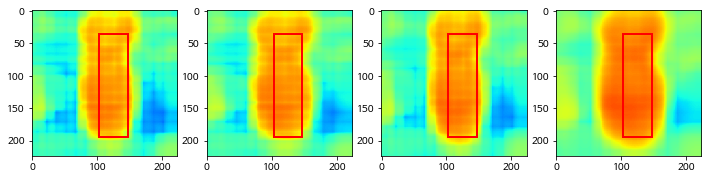

---------- 0.4198646545410156 ------------
True [GT]:1 [Pred]:1 - 0.395
[box_plt] 40 28 107 61


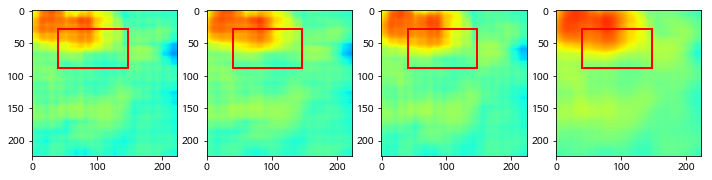

---------- 0.36188387870788574 ------------
True [GT]:3 [Pred]:3 - 0.597
[box_plt] 95 65 53 88


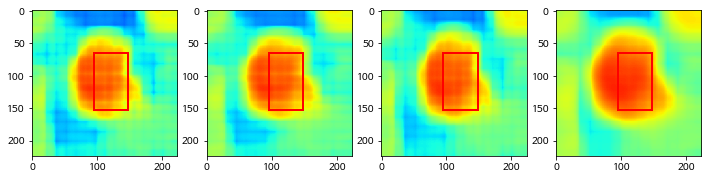

---------- 0.3508877754211426 ------------
True [GT]:2 [Pred]:2 - 0.868
[box_plt] 69 95 85 59


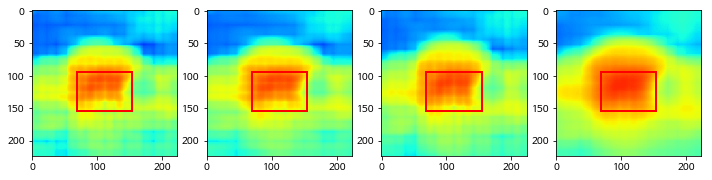

---------- 0.3958749771118164 ------------
False [GT]:4 [Pred]:3 - 0.247
[box_plt] 36 64 125 142


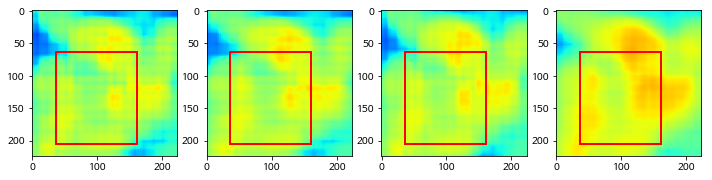

---------- 0.34290575981140137 ------------
True [GT]:2 [Pred]:2 - 0.931
[box_plt] 81 66 74 137


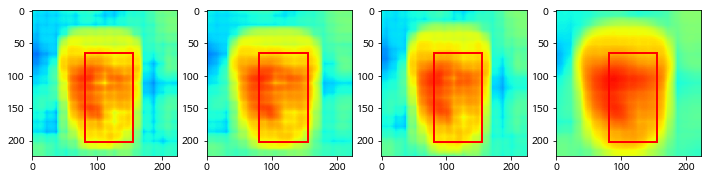

---------- 0.33489203453063965 ------------
False [GT]:2 [Pred]:1 - 0.245
[box_plt] 135 125 79 82


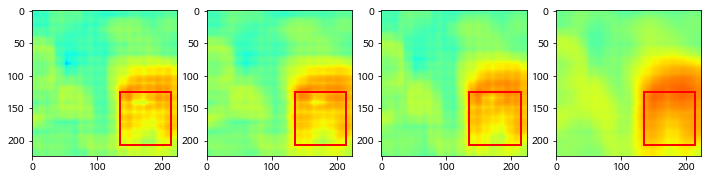

---------- 0.3258962631225586 ------------
True [GT]:0 [Pred]:0 - 0.313
[box_plt] 109 18 63 65


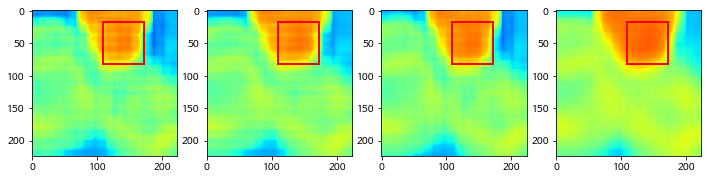

---------- 0.3668839931488037 ------------
True [GT]:1 [Pred]:1 - 0.296
[box_plt] 158 129 51 71


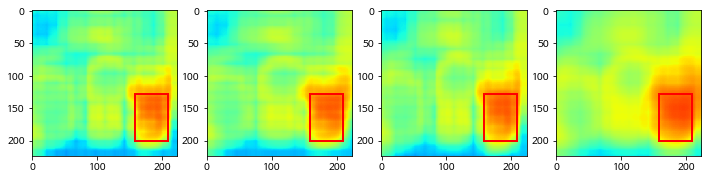

---------- 0.3338944911956787 ------------
True [GT]:1 [Pred]:1 - 0.477
[box_plt] 109 44 63 86


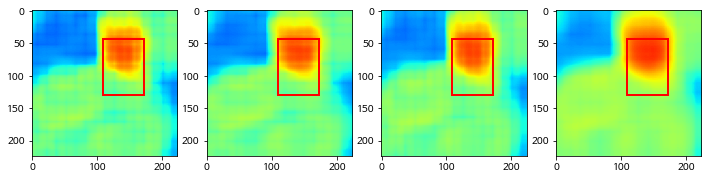

---------- 0.3978574275970459 ------------
True [GT]:2 [Pred]:2 - 0.945
[box_plt] 78 74 84 116


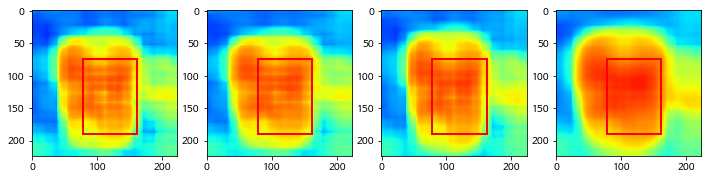

---------- 0.34289002418518066 ------------
True [GT]:1 [Pred]:1 - 0.918
[box_plt] 156 69 58 146


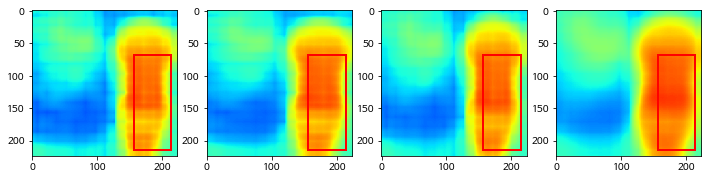

---------- 0.3258957862854004 ------------
True [GT]:2 [Pred]:2 - 0.941
[box_plt] 77 50 115 139


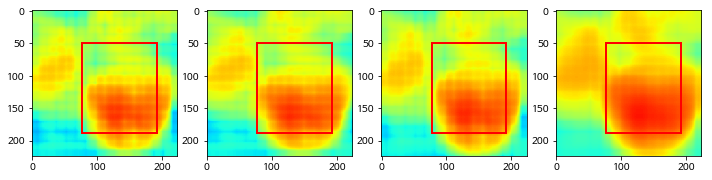

---------- 0.33415770530700684 ------------
True [GT]:0 [Pred]:0 - 0.559
[box_plt] 162 53 48 105


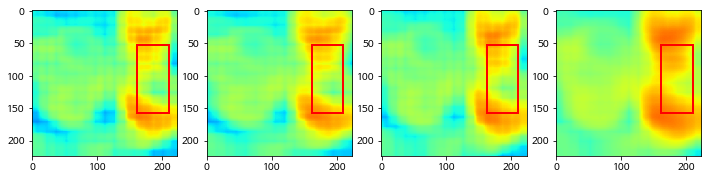

---------- 0.35988616943359375 ------------
True [GT]:4 [Pred]:4 - 0.332
[box_plt] 139 97 51 93


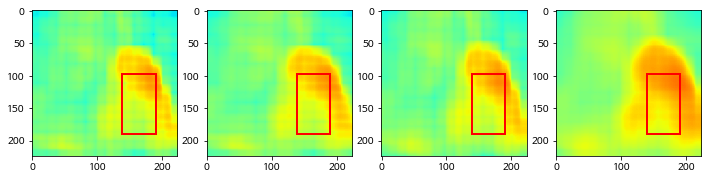

---------- 0.3318948745727539 ------------
True [GT]:3 [Pred]:3 - 0.246
[box_plt] 10 68 90 119


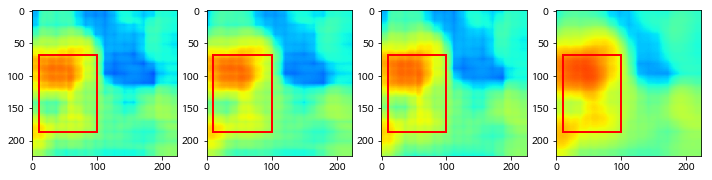

---------- 0.34695935249328613 ------------
True [GT]:3 [Pred]:3 - 0.883
[box_plt] 57 50 96 111


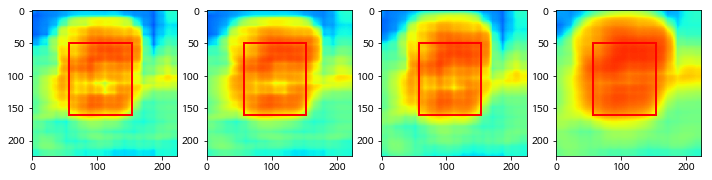

---------- 0.42386412620544434 ------------
True [GT]:4 [Pred]:4 - 0.215
[box_plt] 45 93 98 92


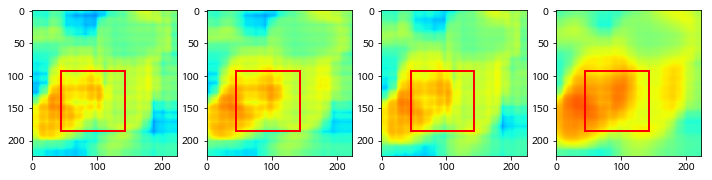

---------- 0.32491135597229004 ------------
True [GT]:4 [Pred]:4 - 0.183
[box_plt] 36 39 158 184


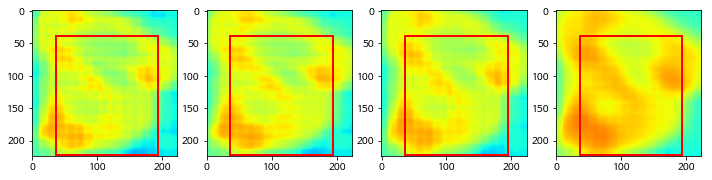

---------- 0.3529033660888672 ------------
True [GT]:2 [Pred]:2 - 0.955
[box_plt] 95 72 113 122


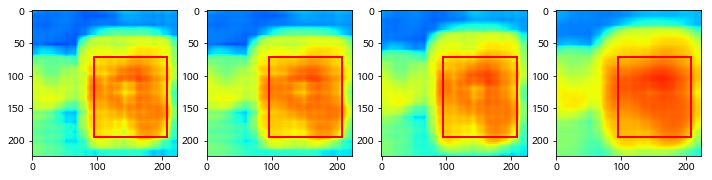

---------- 0.32889246940612793 ------------
True [GT]:4 [Pred]:4 - 0.526
[box_plt] 65 58 124 120


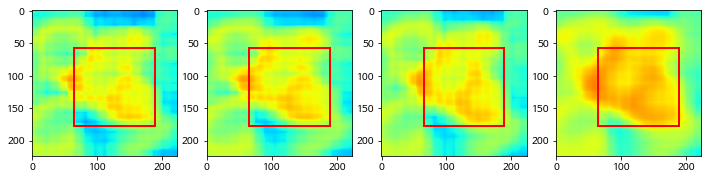

---------- 0.3548698425292969 ------------
True [GT]:3 [Pred]:3 - 0.472
[box_plt] 144 33 70 135


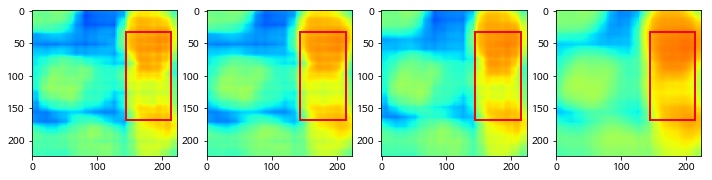

---------- 0.3478879928588867 ------------
True [GT]:0 [Pred]:0 - 0.264
[box_plt] 65 132 54 62


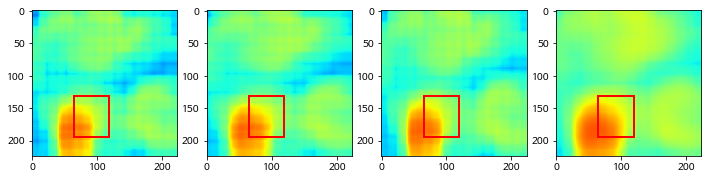

---------- 0.3319118022918701 ------------
True [GT]:3 [Pred]:3 - 0.425
[box_plt] 18 74 78 114


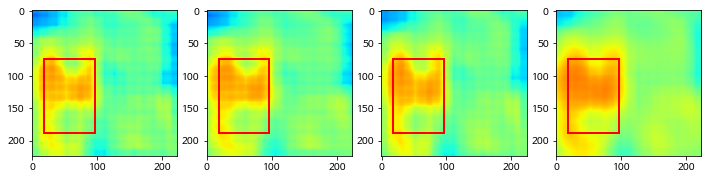

---------- 0.39287376403808594 ------------
True [GT]:1 [Pred]:1 - 0.076
[box_plt] 26 36 75 155


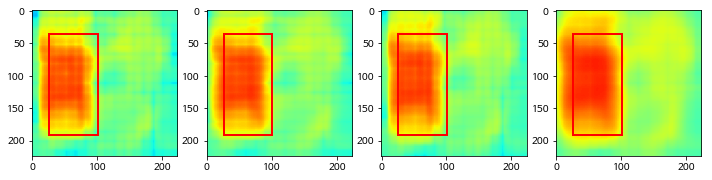

---------- 0.3259134292602539 ------------
True [GT]:2 [Pred]:2 - 0.920
[box_plt] 67 30 85 169


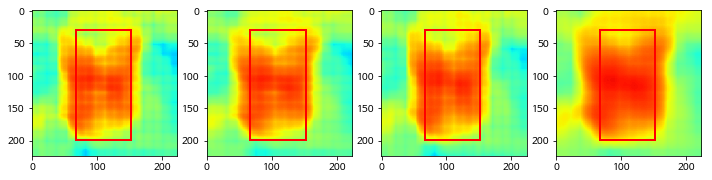

---------- 0.3398737907409668 ------------
True [GT]:3 [Pred]:3 - 0.543
[box_plt] 127 39 96 136


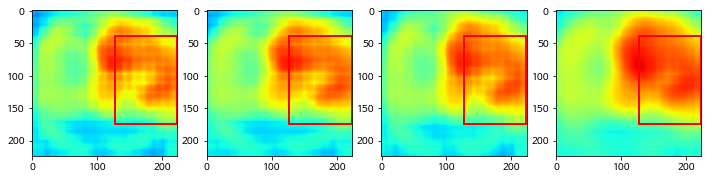

---------- 0.33089470863342285 ------------
True [GT]:0 [Pred]:0 - 0.747
[box_plt] 135 104 75 97


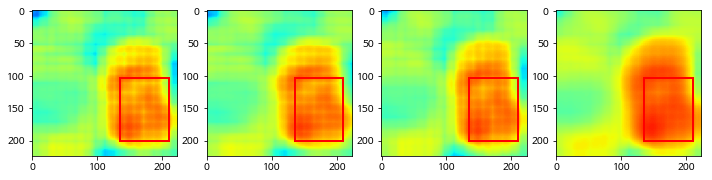

---------- 0.3398926258087158 ------------
True [GT]:4 [Pred]:4 - 0.135
[box_plt] 71 30 89 152


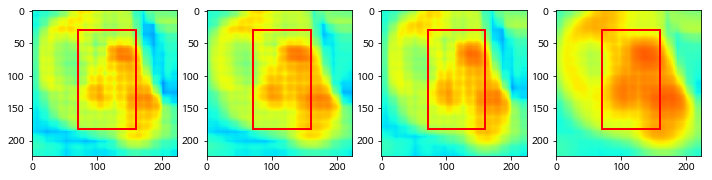

---------- 0.3478868007659912 ------------
True [GT]:3 [Pred]:3 - 0.099
[box_plt] 29 15 117 151


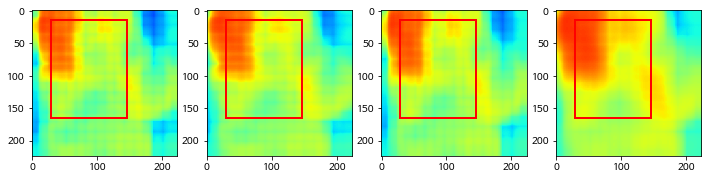

---------- 0.35588502883911133 ------------
True [GT]:1 [Pred]:1 - 0.088
[box_plt] 108 84 78 81


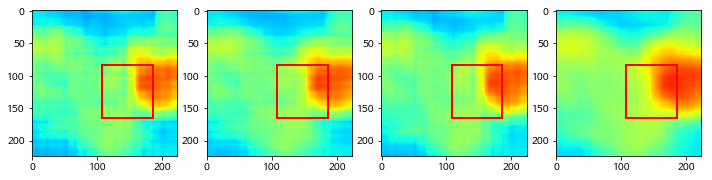

---------- 0.39487361907958984 ------------
True [GT]:0 [Pred]:0 - 0.178
[box_plt] 49 72 43 93


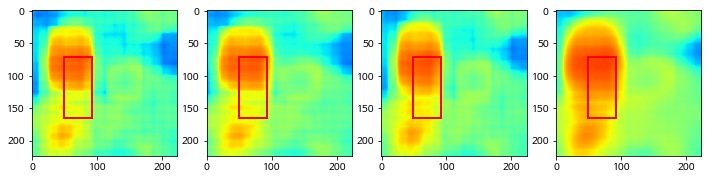

---------- 0.3460392951965332 ------------
True [GT]:4 [Pred]:4 - 0.586
[box_plt] 31 58 157 142


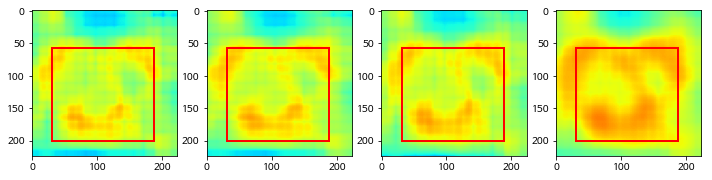

---------- 0.33165478706359863 ------------
True [GT]:1 [Pred]:1 - 0.817
[box_plt] 26 59 82 147


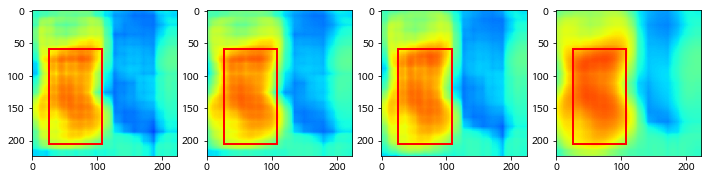

---------- 0.33425283432006836 ------------
True [GT]:0 [Pred]:0 - 0.896
[box_plt] 64 61 102 160


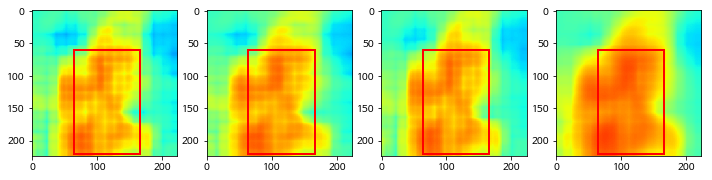

---------- 0.3358924388885498 ------------
False [GT]:4 [Pred]:0 - 0.339
[box_plt] 104 151 79 49


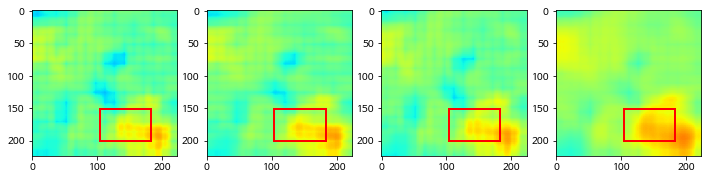

---------- 0.36188554763793945 ------------
True [GT]:0 [Pred]:0 - 0.912
[box_plt] 85 20 64 193


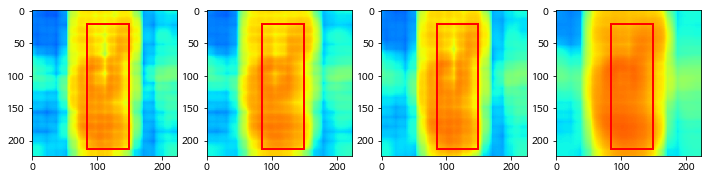

---------- 0.33089351654052734 ------------
True [GT]:3 [Pred]:3 - 0.136
[box_plt] 93 87 58 102


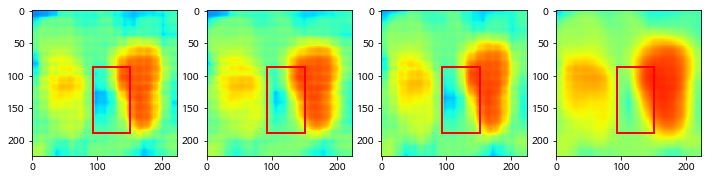

---------- 0.42386436462402344 ------------



In [61]:
# show image
import time
import matplotlib.patches as patches

#  ref - floor, frontview, office // val - floor2, frontview2, wall
# validation_21, reference_21_train // reference_21_val // all_10
# 21 10 바꾸기 주의, MyDataset도 바꿔야함 -10 해야함
# root_dir = '.\\yolo_mark_image\\all_10_office'
# class_path = '.\\yolo_mark_image\\obj_pp10.names'
root_dir = '.\\yolo_mark_image\\store'


# ---------------------------- val set 로드 ---------------------------------

voc_val_dataset = torchvision.datasets.ImageFolder(root=root_dir, 
        transform=transforms.Compose([
        transforms.ToTensor()
    ]))

# voc_val_dataset = MyDataset(root_dir, class_path, 
#         transform=transforms.Compose([
#         transforms.ToTensor()
#     ]))

voc_transform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


# voc_val_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='val', download=False, 
#         transform=transforms.Compose([
#         transforms.ToTensor(),
#     ]))

# voc_val_loader = torch.utils.data.DataLoader(voc_val_dataset, batch_size=1,
#                                           shuffle=True, num_workers=4)

# voc_transform = transforms.Compose([
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])

# assert val_dataset.classes==sample_dir_list, "샘플링 클래스와 데이터로더 클래스가 다름"
# -----------------------`----- val set 정확도 측정 ---------------------------------

fps=0
SHOW_IMAGE = False # 이미지 볼지 말지

# print('[num_class]:', len(sample_dir_list), sample_dir_list)
for idx in tqdm(np.random.permutation(len(voc_val_dataset))):
# for i in tqdm(range(len(voc_val_dataset))):
    startTime = time.time()
    data, targets_gt = voc_val_dataset[idx] # 정답 데이터, 레이블, bbox

    frame_full = data.clone().detach().mul(255).squeeze().numpy().astype(np.uint8).transpose([1,2,0])
    frame_full = cv2.cvtColor(frame_full, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB
    im_tensor = voc_transform(data.squeeze()).to(model.device).data.unsqueeze(0)    
    #-------------------
#     boxes, escore = rpn(frame_full, num_boxs=20, scale=1, min_score=0.01)
#     boxes = rpn2(frame_full, n_slice_x=2, n_slice_y=2, scale=[1,1])
    boxes = rpn3(frame_full, n_slice_x=1, n_slice_y=1)
    # roi align
#     _boxes_cuda = torch.from_numpy(boxes).float().cuda()
#     rois = get_rois(im_tensor, _heatmap, _boxes_cuda)

    heatmap_all = []
    boxes_final = []
    boxes_final_plt = []
    scores = []
    preds = []
    for box in boxes:
    #-------------------    
        bx,by,bw,bh = box.int()
        frame = frame_full[by:by+bh, bx:bx+bw]  
#         frame = cv2.resize(frame, (500,500), 
#                               interpolation=cv2.INTER_CUBIC).astype(np.uint8)
        im_tensor2 = im_tensor[:,:,by:by+bh, bx:bx+bw]
        im_tensor2 = nn.functional.interpolate(im_tensor2, [500,500])
        featuremaps = model(im_tensor2)  

    
        heatmap = textureDetectMultiChannel(featuremaps, stride=(0.25, 0.25), upsample=True)
        heatmap_all.append(heatmap.data)
        
        logit, boxes_adj = boxMaker(heatmap.unsqueeze(0).data)
        pred_d, pred = torch.max(logit, 1)
        boxes_adj_for_frame = cvt_yolobox(boxes_adj[:,pred.item()].detach().cpu().numpy(), frame.shape[:2])
        boxes_adj_for_plt = cvt_yolobox(boxes_adj[:,pred.item()].detach().cpu().numpy(), heatmap.shape[-2:])

        
        x,y,w,h = boxes_adj_for_frame[0]
        boxes_final_plt.append(torch.tensor(boxes_adj_for_plt[0]))
        boxes_final.append(torch.tensor((bx+x, by+y, bx+x+w, by+y+h)))
        scores.append(pred_d.float().sigmoid().item())
        preds.append(pred.item())

    heatmap_all = torch.stack(heatmap_all)
    boxes_final = torch.stack(boxes_final) # x1,y1,x2,y2
    boxes_final_plt = torch.stack(boxes_final_plt) # x,y,w,h
#     scores = scores * escore.flatten()
    scores = torch.tensor(scores).float()
    preds = torch.tensor(preds)
    
#     m = scores>0.5
#     keeps = torchvision.ops.nms(boxes_final[m], scores[m], iou_threshold=0.1)
#     heatmap_all = heatmap_all[m][keeps]
#     boxes_final = boxes_final[m][keeps]
#     boxes_final_plt = boxes_final_plt[m][keeps]
#     scores = scores[m][keeps]
#     preds = preds[m][keeps]
    
    
    for heatmap, box, box_plt, score, pred in zip(heatmap_all, boxes_final, boxes_final_plt, scores, preds):
        xx1,yy1,xx2,yy2 = box.int()
        isRight = pred.item()==targets_gt
#         res = str(score.item())[:5]+'-'+str(targets_gt)+', '+str(pred.item())
        res = str(isRight)+' [GT]:'+str(targets_gt)+' [Pred]:'+str(pred.item())+' - '+str(pred_d.float().sigmoid().item())[:5]
        print(res)  

        if(isRight): # label 맞춤       
            cv2.rectangle(frame_full, (xx1, yy1), (xx2, yy2), (0, 255, 0), 2, cv2.LINE_AA)     
            cv2.putText(frame_full, res, (xx1-3, yy1-10), cv2.FONT_HERSHEY_SIMPLEX, .7, (0,255,0), 2)
        else: # label 틀림 - red
            cv2.rectangle(frame_full, (xx1, yy1), (xx2, yy2), (0, 0, 255), 2, cv2.LINE_AA)     
            cv2.putText(frame_full, res, (xx1-3, yy1-10), cv2.FONT_HERSHEY_SIMPLEX, .7, (0,0,255), 2)
        
        # Create figure and axes ----------------------------
        fig = plt.figure(figsize=(12,12))
        x2,y2,w2,h2 = np.array(box_plt.int())
        print('[box_plt]', x2,y2,w2,h2)
        # Display the image
        for i in range(4):
            ax = fig.add_subplot(1,4, i+1)
            imgplot = ax.imshow(heatmap[pred.item()][i].cpu(), cmap='jet')
            imgplot.set_clim(0,1)

            # Create a Rectangle patch
            rect_pred = patches.Rectangle((x2,y2),w2,h2, linewidth=2,edgecolor='r',facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect_pred)
        plt.show()
        # --------------------------------------------------
        
    cv2.imwrite(os.path.join('test-result-images', 'store-1226', 'res_'+str(idx)+'.jpg'), frame)

    # draw roi
    for idx, b in enumerate(boxes):
        x, y, w, h = b
        cv2.rectangle(frame_full, (x, y), (x+w, y+h), (200, 200, 200), 1, cv2.LINE_AA)
    
    endTime = time.time()
    dur = endTime - startTime
    print('----------',str(dur),'------------')
    # only render UI
    if SHOW_IMAGE:
        # frame = cv2.resize(frame, (int(frame.shape[1]*1.5), int(frame.shape[0]*1.5)), interpolation=cv2.INTER_CUBIC)
        cv2.imshow('frame',frame_full)
        k = cv2.waitKey(0) & 0xff 
        if k == 27: # esc
            break
            
cv2.destroyAllWindows()

In [228]:
cv2.destroyAllWindows()

---
## 시험용 코드

In [18]:
%%time
featuremaps = model(im_tensor)  
heatmap = textureDetectMultiChannel(featuremaps, stride=(0.25, 0.25), upsample=True)

Wall time: 32 ms


In [19]:
featuremaps.shape, heatmap.shape, frame_full.shape

(torch.Size([1, 2048, 11, 19]), torch.Size([5, 4, 224, 224]), (337, 600, 3))

In [20]:
xx = get_rois(frame_full.shape[:2], heatmap, boxes.cuda(), [224,224])

torch.Size([36, 5, 4, 224, 224])


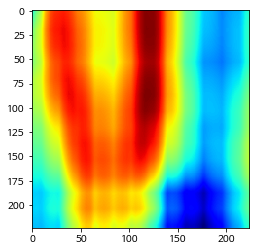

In [21]:
print(xx.shape)
plt.imshow(xx[16][4][1].cpu(), cmap='jet')
plt.show()

In [22]:
# del logit
# del boxMaker
# del xx
# torch.cuda.empty_cache()

In [23]:
'''
gpu 메모리 샌다...
'''
heatmap_all = []
boxes_final = []
boxes_final_plt = []
scores = []
preds = []

for i in range(len(boxes)//10 + 1):
    s = i*10
    e = (i+1)*10
    
    logit, boxes_adj = boxMaker(xx[s:e].data)
    pred_d, pred = torch.max(logit, 1)
    boxes_adj_for_frame = cvt_yolobox(boxes_adj[torch.arange(len(pred)),pred].detach().cpu().numpy(), frame.shape[:2])
    boxes_adj_for_plt = cvt_yolobox(boxes_adj[torch.arange(len(pred)),pred].detach().cpu().numpy(), heatmap.shape[-2:])    
    
        
#     x,y,w,h = boxes_adj_for_frame[0]
    boxes_final_plt.append(torch.tensor(boxes_adj_for_plt).data)
    boxes_final.append(torch.tensor(boxes_adj_for_frame).data)
#     boxes_final.append(torch.tensor((bx+x, by+y, bx+x+w, by+y+h)))
    scores.append(pred_d.float().sigmoid().data)
    preds.append(pred.data)

heatmap_all = torch.stack(heatmap_all)
boxes_final = torch.stack(boxes_final) # x1,y1,x2,y2
boxes_final_plt = torch.stack(boxes_final_plt) # x,y,w,h
scores = torch.tensor(scores)
preds = torch.tensor(preds)

RuntimeError: CUDA out of memory. Tried to allocate 154.00 MiB (GPU 0; 11.00 GiB total capacity; 7.90 GiB already allocated; 134.32 MiB free; 701.35 MiB cached)

In [52]:
print(heatmap.shape)
a = torchvision.ops.roi_align(heatmap, [torch.tensor([[10,20,30,40.], [10,20,30,40.]]).cuda()]*5, [7,7])
b = torchvision.ops.roi_align(heatmap[[1]], [torch.tensor([[10,20,30,40.]]).cuda()], [7,7])
a.shape

torch.Size([5, 4, 224, 224])


torch.Size([10, 4, 7, 7])

In [55]:
# (a[3]-a[2]).sum()
aa = a.reshape(5, 2, *a.shape[1:])
# (a[2]-b[0]).sum()

In [62]:
(aa[1][0]-b[0]).sum()
(a[2]-b[0]).sum()

tensor(0., device='cuda:0')

In [17]:
def get_rois(in_size, featuremaps, bboxes, out_size=[7,7]):
    """
    roi-align from feature map
    @params images - 원본 이미지 (사이즈 계산용)
    @params featuremaps - CNN Backbone 거쳐 나온 것
    @params bboxes - 원본 이미지에서의 bboxes (x,y,w,h)
    @return 피처맵에서 스케일된 bbox부분 7x7로 roi-align된 피처맵
    """
    # calc bbox ratio
    ratio_y = featuremaps.shape[2]/in_size[0]
    ratio_x = featuremaps.shape[3]/in_size[1]
    bboxes_scaled = bboxes.clone()#.detach()

    bboxes_scaled[:,0] = bboxes_scaled[:,0]*ratio_x # for x
    bboxes_scaled[:,1] = bboxes_scaled[:,1]*ratio_y # for y
    bboxes_scaled[:,2] = bboxes_scaled[:,2]*ratio_x # for w
    bboxes_scaled[:,3] = bboxes_scaled[:,3]*ratio_y # for h

    # x,y,w,h -> x1, y1, x2, y2 그래디언트 학습되는 변수가 아니므로 inplace 계산 들어가도 괜찮다
    bboxes_scaled[:, 2] = bboxes_scaled[:, 0] + bboxes_scaled[:, 2]
    bboxes_scaled[:, 3] = bboxes_scaled[:, 1] + bboxes_scaled[:, 3]
    
    crops = torchvision.ops.roi_align(featuremaps, [bboxes_scaled]*featuremaps.shape[0], out_size)
    crops = crops.reshape(featuremaps.shape[0], -1, *crops.shape[1:]).transpose(0,1)
    return crops